In [1]:
# Purpose: Preparing the perturbation forcing for the basin-wide experiments, 
#          i.e. only forcing the Pacific Ocean, the Atlantic Ocean or the 
#          Indian Ocean
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 17. 09. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps                                                                   
import os.path # to check if file exists
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.mpl.ticker as cticker
from matplotlib import ticker

import cartopy.feature as cfeature

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "
myblue = [.19, .21, .58]
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

from dask.distributed import Client
client = Client(n_workers=16)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46699 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43337 Dashboard: /proxy/46699/status,Cluster Workers: 16 Cores: 16 Memory: 250.00 GiB


### Preparation of masks

In [2]:
%%time
# load JRA55-do data and create the masks
# climatological mask = everywhere 1962-1972 data except the tropics where there are zero values
# tropics mask = 1972-2018 data only in the tropics with zero values everywhere else

base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/tas/gr/v20190429/'
fname = 'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_'

south_bound = -35 # -42.5 

for resolution in [0]:                 # loop over all years
    if resolution == 0:
        ds1 = xr.open_mfdataset(base + fname + '1958*',combine = 'by_coords', chunks = {'time': 1},decode_times = True) # open dataset
        ds = ds1.tas[1,:,:] # plot everywhere zero values except over land where we have nan
        dims = [320, 640] # dimensions of lat and lon
        print('resolution = 0, i.e. preparing basin_masks for JRA55-do')
    if resolution == 1:
        ds1 = xr.open_mfdataset('/g/data/e14/mv7494/access-om2/archive/1deg_jra55_iaf_branch2000/output201/ocean/ocean.nc',decode_times = True)
        ds = ds1.temp[0,0,:,:].rename({'yt_ocean': 'lat', 'xt_ocean': 'lon'}) 
        dims = [300, 360]
        print('resolution = 1, i.e. preparing basin_masks for ACCESS-OM2-1')


    # Indian Ocean fertig
    indo_map = (ds.where(ds.lat < 30.5).where(ds.lat > south_bound).where(ds.lon >20).where(ds.lon<100)).fillna(0)
    indo_map2 = (ds.where(ds.lat < -8).where(ds.lat > south_bound).where(ds.lon >100).where(ds.lon<142)).fillna(0)
    indo_map3 = (ds.where(ds.lat < -1).where(ds.lat > -8).where(ds.lon >100).where(ds.lon<104)).fillna(0)
    indo_map4 = (ds.where(ds.lat < -3).where(ds.lat > -8).where(ds.lon >104).where(ds.lon<106)).fillna(0) # to Arnhem land
#     indo_map5 = (ds.where(ds.lat < -34).where(ds.lat > -90).where(ds.lon >20).where(ds.lon<142)).fillna(0) # Southern Ocean Sector
#     indo_map6 = (ds.where(ds.lat < -34).where(ds.lat > -90).where(ds.lon >142).where(ds.lon<147)).fillna(0) # Southern Ocean Sector 2
                                                                   # do not include the Southern Ocean sector
    indo_sector_map = indo_map + indo_map2 + indo_map3 + indo_map4 #+ indo_map5 + indo_map6
    indo_sector_map = indo_sector_map.where(indo_sector_map == 0,1)


    # Pacific Ocean fertig
    pac_map = (ds.where(ds.lat < 66).where(ds.lat > -1).where(ds.lon >100).where(ds.lon<260)).fillna(0) # Pacific north
    pac_map2 = (ds.where(ds.lat < -1).where(ds.lat > -3).where(ds.lon >104).where(ds.lon<295)).fillna(0) # bit Malaya
    pac_map3 = (ds.where(ds.lat < -3).where(ds.lat > -8).where(ds.lon >106).where(ds.lon<295)).fillna(0) # bit Malaya
    pac_map4 = (ds.where(ds.lat < 9).where(ds.lat > -1).where(ds.lon >260).where(ds.lon<295)).fillna(0) # through Panama
    pac_map5 = (ds.where(ds.lat < 18).where(ds.lat > 9).where(ds.lon >260).where(ds.lon<271)).fillna(0) # South of Yucatan
    pac_map6 = (ds.where(ds.lat < 15).where(ds.lat > 9).where(ds.lon >271).where(ds.lon<276)).fillna(0) # Guatemala bit
    pac_map7 = (ds.where(ds.lat < -8).where(ds.lat > south_bound).where(ds.lon >142).where(ds.lon<295)).fillna(0) # to Arnhem land
#     pac_map8 = (ds.where(ds.lat < -8).where(ds.lat > -90).where(ds.lon >147).where(ds.lon<290)).fillna(0) # Southern Ocean Sector
                                                                                               # do not include the Southern Ocean sector
    pac_sector_map = pac_map + pac_map2 + pac_map3 + pac_map4 + pac_map5 + pac_map6 + pac_map7 #+ pac_map8
    pac_sector_map = pac_sector_map.where(pac_sector_map == 0,1)

    # Atlantic Ocean fertig
    atl_map = (ds.where(ds.lat < 90).where(ds.lat > 66).where(ds.lon >0).where(ds.lon<360)).fillna(0) # Atlantic north
    atl_map1 = (ds.where(ds.lat < 66).where(ds.lat > 18).where(ds.lon >260).where(ds.lon<360)).fillna(0) # Atlantic north of Yocatan
    atl_map2 = (ds.where(ds.lat < 18).where(ds.lat > south_bound).where(ds.lon >294).where(ds.lon<360)).fillna(0) # Atlantic south
    atl_map3 = (ds.where(ds.lat < 18).where(ds.lat > south_bound).where(ds.lon >0).where(ds.lon<20)).fillna(0) # Atlantic south
    atl_map4 = (ds.where(ds.lat < 15).where(ds.lat > 9).where(ds.lon >276).where(ds.lon<294)).fillna(0) # Atlantic south
    atl_map5 = (ds.where(ds.lat < 18).where(ds.lat > 15).where(ds.lon >271).where(ds.lon<294)).fillna(0) # South of Yucatan
    atl_map6 = (ds.where(ds.lat < 66).where(ds.lat > 30).where(ds.lon >0).where(ds.lon<100)).fillna(0) # South of Yucatan
    atl_map7 = (ds.where(ds.lat < 30).where(ds.lat > 18).where(ds.lon >0).where(ds.lon<20)).fillna(0) # South of Yucatan
#     atl_map8 = (ds.where(ds.lat < -34).where(ds.lat > -90).where(ds.lon >290).where(ds.lon<360)).fillna(0) # Southern Ocean Sector
#     atl_map9 = (ds.where(ds.lat < -8).where(ds.lat > -90).where(ds.lon >0).where(ds.lon<20)).fillna(0) # Southern Ocean Sector 2
                                                                                                          # do not include the Southern Ocean sector
    atl_sector_map = atl_map + atl_map1 + atl_map2 + atl_map3 + atl_map4 + atl_map5 + atl_map6 + atl_map7 #+ atl_map8 + atl_map9
    atl_sector_map = atl_sector_map.where(atl_sector_map == 0,1)


    # get the Southern Ocean map, going from 90°S to 45°S with the tapering to 40°S
    southern_sector_map = (ds.where(ds.lat < -45).where(ds.lat > -90).where(ds.lon >0).where(ds.lon<360)).fillna(0) # Southern Ocean Sector
    southern_sector_map = southern_sector_map.where(southern_sector_map == 0,1)
 
    # get the Northern Ocean map, going from 45°S to 90°N with the tapering to 40°S
    northern_sector_map = (ds.where(ds.lat > -45).where(ds.lat < 90).where(ds.lon >0).where(ds.lon<360)).fillna(0) # Southern Ocean Sector
    northern_sector_map = northern_sector_map.where(northern_sector_map == 0,1)
    

    # get the tropics 30SN map, going from 30°S to 30°N with the tapering to 35°S and 35°N
    tropics_30SN_map = (ds.where(ds.lat < 30).where(ds.lat > -30).where(ds.lon >0).where(ds.lon<360)).fillna(0) # Southern Ocean Sector
    tropics_30SN_map = tropics_30SN_map.where(tropics_30SN_map == 0,1)

    extratropics_30SN_map = abs(tropics_30SN_map-1) # switch all values in a clever way
                                                    # Ausgang, Operation, Endresultat
                                                    # 0 -> abs(0-1) = 1
                                                    # 1 -> abs(1-1) = 0
                                                    # 0 -> abs(0-1) = 1

    wind_map = (ds).fillna(0)
    wind_map = wind_map.where(wind_map == 0,1)


    

    # fig = plt.figure(figsize=(20,20),tight_layout=True,facecolor='w',edgecolor='k')
    # ax = [plt.subplot(111, projection=ccrs.PlateCarree()),]
    # ax[0].set_title('Indian Ocean MASK'); atl_sector_map.plot(ax=ax[0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=True); ax[0].coastlines()

  

    ### Tapering of basin-wide masks, each with a Southern Ocean sector
    # -----------------------------------------------------------------------
    for m in range(8): # loop through the basins Pacific, Atlantic and Indian Ocean
        if m == 0: a = pac_sector_map.values
        if m == 1: a = atl_sector_map.values
        if m == 2: a = indo_sector_map.values
        if m == 3: a = southern_sector_map.values
        if m == 4: a = northern_sector_map.values
        if m == 5: a = tropics_30SN_map.values
        if m == 6: a = extratropics_30SN_map.values
        if m == 7: a = wind_map.values
      
            
        # this below here is super very much inefficient but hey it works! ....takes ages probably as well haha
        for y in range(1,dims[0]-1):
            for x in range(1,dims[1]-1):
                if a[y,x] == 0 and a[y,x+1] == 1: a[y,x] = .8        # western boundary     
                if a[y,x] == 1 and a[y,x+1] == 0: a[y,x+1] = .8      # eastern boundary 
                if a[y,x] == 0 and a[y+1,x] == 1: a[y,x] = .8      # southern boundary
                if a[y,x] == 1 and a[y+1,x] == 0: a[y+1,x] = .8      # northern boundary           
        for y in range(1,dims[0]-1):
            for x in range(1,dims[1]-1):           
                if a[y,x] == 0 and np.round(a[y,x+1]*10,1) == 8: a[y,x] = .6        # western boundary     
                if np.round(a[y,x]*10,1) == 8 and a[y,x+1] == 0: a[y,x+1] = .6      # eastern boundary 
                if a[y,x] == 0 and np.round(a[y+1,x]*10,1) == 8: a[y,x] = .6      # southern boundary
                if np.round(a[y,x]*10,1) == 8 and a[y+1,x] == 0: a[y+1,x] = .6      # northern boundary        
        # the strange work-around with np.round(x*10) is necessary as only True/False statement with integers
        # each time a new loop as else values cannot be overwritten 
        for y in range(1,dims[0]-1):
            for x in range(1,dims[1]-1):
                if a[y,x] == 0 and np.round(a[y,x+1]*10,1) == 6: a[y,x] = .4        # western boundary     
                if np.round(a[y,x]*10,1) == 6 and a[y,x+1] == 0: a[y,x+1] = .4      # eastern boundary 
                if a[y,x] == 0 and np.round(a[y+1,x]*10,1) == 6: a[y,x] = .4      # southern boundary
                if np.round(a[y,x]*10,1) == 6 and a[y+1,x] == 0: a[y+1,x] = .4      # northern boundary
        for y in range(1,dims[0]-1):
            for x in range(1,dims[1]-1):
                if a[y,x] == 0 and np.round(a[y,x+1]*10,1) == 4: a[y,x] = .2        # western boundary     
                if np.round(a[y,x]*10,1) == 4 and a[y,x+1] == 0: a[y,x+1] = .2      # eastern boundary 
                if a[y,x] == 0 and np.round(a[y+1,x]*10,1) == 4: a[y,x] = .2      # southern boundary
                if np.round(a[y,x]*10,1) == 4 and a[y+1,x] == 0: a[y+1,x] = .2      # northern boundary

        # replace all values, i.e. switch them around
    #     b = a.where(a != 1,11);  b = b.where(a != 0,1);    b = b.where(a != 11,0);  
    #     b = b.where(a != .8,11); b = b.where(a != .2,.8);  b = b.where(a != 11,.2);  
    #     b = b.where(a != .6,11); b = b.where(a != .4,.6); b = b.where(a != 11,.4);

        # allocate array to name each iteration
        if m == 0: iaf_mask_pacific = a; 
        if m == 1: iaf_mask_atlantic = a; 
        if m == 2: iaf_mask_indian = a;  
        if m == 3: iaf_mask_southern = a; 
        if m == 4: iaf_mask_northern = a; 
        if m == 5: iaf_mask_tropics_30SN = a; 
        if m == 6: iaf_mask_extratropics_30SN = a; 
        if m == 7: iaf_mask_wind = wind_map-1; # for the EXP_Wind-JRA55-do-1-3 experiment, IAF mask is all zeroes
            
        # create rdf mask as well
        b = np.copy(a) # copy over the same array and flip all values so it is exactly the opposite
        b[b == 1] = 11;  b[b == 0] = 1;   b[b == 11] = 0 
        b[b == .8] = 11; b[b == .2] = .8; b[b == 11] = .2
        b[b == .6] = 11; b[b == .4] = .6; b[b == 11] = .4

        # allocate array to name each iteration
        if m == 0: rdf_mask_pacific = b; 
        if m == 1: rdf_mask_atlantic = b; 
        if m == 2: rdf_mask_indian = b;
        if m == 3: rdf_mask_southern = b;
        if m == 4: rdf_mask_northern = b;  
        if m == 5: rdf_mask_tropics_30SN = b;
        if m == 6: rdf_mask_extratropics_30SN = b;  
        if m == 7: rdf_mask_wind = wind_map; # ... and likewise the RDF mask is all ones



    # save back into xarray structure and save as .netcdf file  
    ds3 = xr.Dataset({'tas': ds, 
                      'iaf_mask_pacific': (('lat', 'lon'), iaf_mask_pacific),
                      'iaf_mask_atlantic': (('lat', 'lon'), iaf_mask_atlantic),
                      'iaf_mask_indian': (('lat', 'lon'), iaf_mask_indian),
                      'iaf_mask_southern': (('lat', 'lon'), iaf_mask_southern),
                      'iaf_mask_northern': (('lat', 'lon'), iaf_mask_northern),
                      'iaf_mask_tropics_30SN': (('lat', 'lon'), iaf_mask_tropics_30SN),
                      'iaf_mask_extratropics_30SN': (('lat', 'lon'), iaf_mask_extratropics_30SN),
                      'iaf_mask_wind': (('lat', 'lon'), iaf_mask_wind),
                      'rdf_mask_pacific': (('lat', 'lon'), rdf_mask_pacific),
                      'rdf_mask_atlantic': (('lat', 'lon'), rdf_mask_atlantic),
                      'rdf_mask_indian': (('lat', 'lon'), rdf_mask_indian),
                      'rdf_mask_southern': (('lat', 'lon'), rdf_mask_southern),
                      'rdf_mask_northern': (('lat', 'lon'), rdf_mask_northern),
                      'rdf_mask_tropics_30SN': (('lat', 'lon'), rdf_mask_tropics_30SN),
                      'rdf_mask_extratropics_30SN': (('lat', 'lon'), rdf_mask_extratropics_30SN),
                      'rdf_mask_wind': (('lat', 'lon'), rdf_mask_wind)})   

    if resolution == 0:
        os.system('rm -r /g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_perturbation_runs.nc')
        ds3.to_netcdf('/g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_perturbation_runs.nc') 
    if resolution == 1:
        os.system('rm -r /g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_perturbation_runs_1deg_resolution.nc')
        ds3.to_netcdf('/g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_perturbation_runs_1deg_resolution.nc')

# Wall time: 3min 13s

resolution = 0, i.e. preparing basin_masks for JRA55-do
CPU times: user 3min 28s, sys: 2.78 s, total: 3min 31s
Wall time: 3min 57s


### Plotting routine for only Pacific, Indian and Atlantic masks

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'cmp'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
<timed exec>:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


CPU times: user 3.69 s, sys: 423 ms, total: 4.11 s
Wall time: 4.08 s


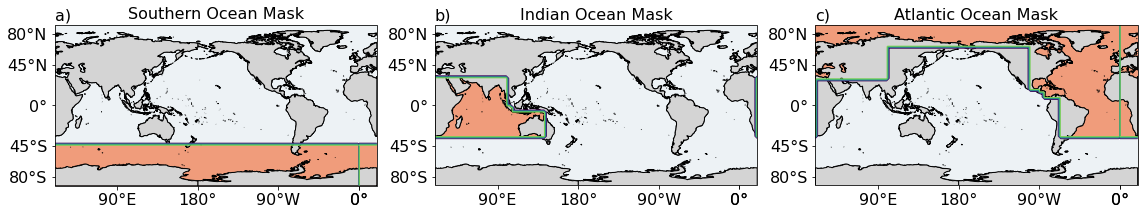

In [3]:
%%time
def fancy_plot(axes_nr):
    '''
    This function creates my specifics for the global plot, i.e.
    coastlines, land colour, gridlines and labels (30°lat, 60°lon)
    input:
        - axes_nr -> number of subplot, i.e. ax1 for subplot(2,2,1)
    '''
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-80,-45,0,45,80], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "

    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)

    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
# farbe = rotblau[0:4] # red contours
farbe = rotblau[16:20] # blue contours

# initialise figure
fig = plt.figure(figsize=(16,8),tight_layout=True,facecolor='w',edgecolor='k')

ax1 = plt.subplot(1,3,1, projection=ccrs.PlateCarree(central_longitude=200)) # longitude starting at Cape Agulhas (20°E) 
ticks = np.linspace(-2,2,num=21) # ticks for colour bar
ax1.set_extent([1, 360, -90,90], crs=ccrs.PlateCarree())

p1 = ds3.iaf_mask_southern.plot.contourf(cmp='tab10',levels=ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p22 = ds3.iaf_mask_southern.plot.contour(linewidths=1, transform=ccrs.PlateCarree())
plt.title('Southern Ocean Mask', fontsize=16) # title
ax1.text(0, 1.03,string.ascii_lowercase[0]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
fancy_plot(ax1) # add land boundaries, fill in land and add labels in °S/°N form
ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1) # zorder 1 to plot contours above the filled land area

ax1 = plt.subplot(1,3,2, projection=ccrs.PlateCarree(central_longitude=200)) # longitude starting at Cape Agulhas (20°E) 
p1 = ds3.iaf_mask_indian.plot.contourf(cmp='tab10',levels=ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p22 = ds3.iaf_mask_indian.plot.contour(linewidths=1, transform=ccrs.PlateCarree())
plt.title('Indian Ocean Mask', fontsize=16) # title
ax1.text(0, 1.03,string.ascii_lowercase[1]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
fancy_plot(ax1) # add land boundaries, fill in land and add labels in °S/°N form
ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1) # zorder 1 to plot contours above the filled land area

ax1 = plt.subplot(1,3,3, projection=ccrs.PlateCarree(central_longitude=200)) # longitude starting at Cape Agulhas (20°E) 
p1 = ds3.iaf_mask_atlantic.plot.contourf(cmp='tab10',levels=ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p22 = ds3.iaf_mask_atlantic.plot.contour(linewidths=1, transform=ccrs.PlateCarree())
plt.title('Atlantic Ocean Mask', fontsize=16) # title
ax1.text(0, 1.03,string.ascii_lowercase[2]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
fancy_plot(ax1) # add land boundaries, fill in land and add labels in °S/°N form
ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1) # zorder 1 to plot contours above the filled land area


# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'boundaries_north_basin_mask', dpi=300, facecolor='w',  edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)
# --------------------------------------------------------------------------- #

### Plotting routine of all masks, i.e. the tropics/extratropics and basin-wide ones

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
<timed exec>:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
<timed exec>:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


CPU times: user 5.98 s, sys: 827 ms, total: 6.8 s
Wall time: 6.16 s


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


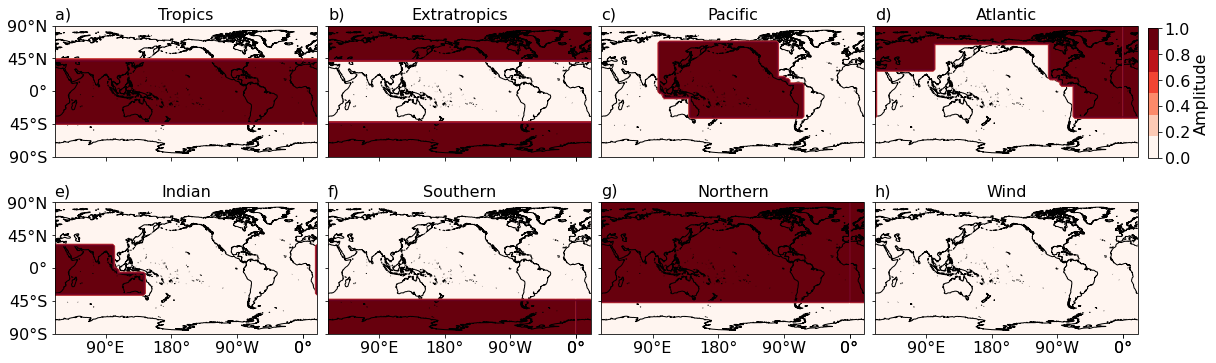

In [4]:
%%time
ds2 = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_tropics_extratropics_runs.nc') 
ds3 = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_perturbation_runs.nc')  
plot_range = [-90,90]; ticks=np.linspace(0,1,7)

# initialise figure
fig = plt.figure(figsize=(16, 6),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,4) 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def fancy_plot(axes_nr):
    '''
    This function creates my specifics for the global plot, i.e.
    coastlines, land colour, gridlines and labels (30°lat, 60°lon)
    input:
        - axes_nr -> number of subplot, i.e. ax1 for subplot(2,2,1)
    '''
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-90,-45,0,45,90], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False);axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

farbe = [rotblau[4],rotblau[3],rotblau[2],rotblau[1],rotblau[0]] # red contours
for f in range(8):
    if f == 0:
        data = ds2.iaf_mask_tropics; panel = gs[0,0]; titles = 'Tropics'; nr = 0 # suplot number for label on top left
        contour = ds2.iaf_mask_tropics
    elif f == 1:
        data = ds2.iaf_mask_extratropics; panel = gs[0,1]; titles = 'Extratropics'; nr = 1
        contour = ds2.iaf_mask_extratropics
    if f == 2:
        data = ds3.iaf_mask_pacific; panel = gs[0,2]; titles = 'Pacific'; nr = 2
        contour = ds3.iaf_mask_pacific
    if f == 3:
        data = ds3.iaf_mask_atlantic; panel = gs[0,3]; titles = 'Atlantic'; nr = 3 
        contour = ds3.iaf_mask_atlantic
    if f == 4:
        data = ds3.iaf_mask_indian; panel = gs[1,0]; titles = 'Indian'; nr = 4 
        contour = ds3.iaf_mask_indian
    if f == 5:
        data = ds3.iaf_mask_southern; panel = gs[1,1]; titles = 'Southern'; nr = 5
        contour = ds3.iaf_mask_southern
    if f == 6:
        data = ds3.iaf_mask_northern; panel = gs[1,2]; titles = 'Northern'; nr = 6
        contour = ds3.iaf_mask_northern
    if f == 7:
        data = ds3.iaf_mask_wind; panel = gs[1,3]; titles = 'Wind'; nr = 7
        contour = ds3.iaf_mask_wind
    # --- panel creation ---------------------------------------------------------- #
    ax1 = plt.subplot(panel, projection=ccrs.PlateCarree(central_longitude=200))
    ax1.set_extent([1, 360, -90, 90], crs=ccrs.PlateCarree())
    p2 = data.plot.contourf(levels=ticks, cmap='Reds',
                                     add_colorbar=False,extend='neither',transform=ccrs.PlateCarree())
    p22 = contour.plot.contour(linewidths=1, colors=farbe, transform=ccrs.PlateCarree())
    plt.title(titles, fontsize=16) # title
    ax1.text(0, 1.05,string.ascii_lowercase[nr]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
    fancy_plot(ax1);
    if f in [0,1,2,3]:
        ax1.set_xticklabels([], minor=False)
    if f in [1,2,3,5,6,7]:
        ax1.set_yticklabels([], minor=False)
# add colour bar
cax = fig.add_axes([1, 0.55, 0.008, 0.3]) # position: [x0, y0, width, height]
cb = plt.colorbar(p2, cax = cax, shrink=.25, orientation='vertical'); 
cb.set_label(label='Amplitude', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator;cb.update_ticks() 

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'JRA55_basin_mask_preparation_for_forcing', 
            dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #

### Here the HEAVY-LIFTING: Preparation of forcing fields for the three basin-wide simulations

#### Achtung, zuerst den leeren Ordner mit Unterordern für alle Variablen erstellen bevor ich das Skript laufen lasse
> mkdir EXP_Southern_JRA55-do-1-3 \
> cd EXP_Southern_JRA55-do-1-3 \
> mkdir friver huss prra prsn psl rlds rsds tas uas vas

In [8]:
# combining RDF and IAF forcing into a netcdf file                                                             #
ds3 = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_perturbation_runs.nc')       #  
# --- which forcing to use, either JRA55-do-1-3 or JRA55-do-1-4-0                                              #
forcing = '1-3'                                                                                                #
storage = 'e14' # specify which storage folder on /g/data                                                     #
# ------------------------------------------------------------------------------------------------------------ #

for e in [7]:#range(8):
    # to accommodate the different forcing which has different naming conventions
    if forcing == '1-3':
        base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
        fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
        version = 'gn/v20180412/'
        hrPt_timestep = ['01010000','12312230']
        hr_timestep = ['01010130','01010000']
        day_timestep = ['0101','0101']
        if e == 0: 
            experiment = 'EXP_Pacific_JRA55-do-1-3/'
            iaf_mask = ds3.iaf_mask_pacific
            rdf_mask = ds3.rdf_mask_pacific
        elif e == 1: 
            experiment = 'EXP_Atlantic_JRA55-do-1-3/'
            iaf_mask = ds3.iaf_mask_atlantic
            rdf_mask = ds3.rdf_mask_atlantic
        elif e == 2: 
            experiment = 'EXP_Indian_JRA55-do-1-3/'  
            iaf_mask = ds3.iaf_mask_indian
            rdf_mask = ds3.rdf_mask_indian
        elif e == 3: 
            experiment = 'EXP_Southern_JRA55-do-1-3/'  
            iaf_mask = ds3.iaf_mask_southern
            rdf_mask = ds3.rdf_mask_southern
        elif e == 4: 
            experiment = 'EXP_Northern_JRA55-do-1-3/'  
            iaf_mask = ds3.iaf_mask_northern
            rdf_mask = ds3.rdf_mask_northern
        elif e == 5: 
            experiment = 'EXP_Tropics_30SN_JRA55-do-1-3/'  
            iaf_mask = ds3.iaf_mask_tropics_30SN
            rdf_mask = ds3.rdf_mask_tropics_30SN
        elif e == 6: 
            experiment = 'EXP_Extratropics_30SN_JRA55-do-1-3/'  
            iaf_mask = ds3.iaf_mask_extratropics_30SN
            rdf_mask = ds3.rdf_mask_extratropics_30SN
        elif e == 7: 
            experiment = 'EXP_Wind-Radiation_JRA55-do-1-3/'
            iaf_mask = ds3.iaf_mask_wind
            rdf_mask = ds3.rdf_mask_wind

    print('#########################################')    
    print('        '+experiment+'        ')
    print('#########################################')    
    print('') 
    var = ['huss','prra','prsn','psl','rlds','rsds','tas','uas','vas'] # only eight of the variables I used in my Msc

    a = np.linspace(1972,2018,47) # years 1958, 1959, 1960, ..., 2017


    # repeating the 1962-1971 period 4.6 times to build one repeating list
    b = np.linspace(1962,1971,10)
    b = np.concatenate((b, b, b, b, [1962,1963,1964,1965,1966,1967]), axis=0)

    # ok, this is great. Now I have two lists, one cycling through the 1962-1971 climatological period and the other going
    # from 1972-2018 with the IAF perturbation in the tropics

    startTime = datetime.now() # start clock     

    for i in range(0,9):            # loop over the JRA55 variables,          range(0,9):
        for year in range(0,46):          # loop over all years from 1972-2018,    range(0,46):
            year_a = str(int(a[year]))
            year_aa = str(int(a[year+1]))
            year_b = str(int(b[year]))       
            startTime = datetime.now()    # start clock     

            # get correct subfolder, either 'atmos', 'land' or 'landIce'
            if var[i] == 'friver' and forcing == '1-3':
                domain = 'ocean/'
            elif var[i] == 'friver' and forcing == '1-4-0':
                domain = 'land/'
            elif var[i] == 'licalvf':
                domain = 'landIce/'
            else:
                domain = 'atmos/'

            # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
            if var[i] in ['rsds','rlds','prra','prsn']:
                res = '3hr/'
            elif var[i] in ['psl','tas','huss','uas','vas']:
                res = '3hrPt/'
            else:
                res = 'day/'

            # load in data for interannual IAF forcing 
            ds1 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_a + '*',combine = 'by_coords', 
                                    chunks = {'time': 1},decode_times = True) # open dataset  
            #ds1 = ds1.sel(time = year_a + '-01-01') # only select subset of data


            # load in data for climatological RDF forcing 
            ds2 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_b + '*',combine = 'by_coords', 
                                    chunks = {'time': 1},decode_times = True) # open dataset


            # leap day adjustment, either add or remove 29th of Feb. so the clim. and IAF forcing match
            # the adjustment takes place in the ds2, i.e. climatological data
            # see also file presentation20200511.ppt in the autumn semester 2020 folder
            if year_a in ['1972','1976','1980','1992','1996','2000','2012', '2016']:
                # in these yeas I have to add a leap day in the clim. files as a copy of 28th of Feb
                #print(year_b)  

                # --- in this section I add a leap day

                new_attrs = {**ds2.time.attrs} # keep the time attributes for later use
                day_length=ds2.time.size//365 # day_length = 8, 6-hourly data

                # extract the 28th of February
                ds2_29 = ds2.isel(time=slice((31+27)*day_length,(31+28)*day_length)) 

                # day_shift is 1 as the unit of the time array is day here.
                # But it could be more if time was in hours for example.
                # See the time attributes for the unit.
                day_shift = ds2.time.values[day_length] - ds2.time.values[0] 
                ds2_29.time.values[:] += day_shift

                # Create a 1 day "hole" in original time coordinate:
                ds2.time.values[-day_length:] += day_shift

                ds2 = xr.concat((ds2,ds2_29),dim="time") # yes, great now the time vector has 2928 entries instead of 2920 (no leap days)

                # We see the result isn't quite right as the time dimension isn't ordered. Just need a sort:
                ds2 = ds2.sortby(ds2.time)

                # Now we change the calendar to all_leap and decode the times:
                new_attrs["calendar"] = "all_leap"
                time = ds2.time
                time = time.assign_attrs(**new_attrs)
                ds2 =ds2.assign_coords({"time":time})

                print('Year ' + year_a + ' & ' + var[i] + ': leap day added')   

            elif year_a in ['1974', '1978', '1994', '1998', '2014']:
                # in these yeas I have to remove the leap day in the clim. files 
                ds2 = ds2.sel(time=~((ds2.time.dt.month == 2) & (ds2.time.dt.day == 29)))
                print('Year ' + year_a + ' & ' + var[i] + ': leap day deleted')   
            else:
                print('Year ' + year_a + ' & ' + var[i] + ': no adjustment')   
            ds2['time'] = ds1.time # overwrite time vector so that the 'interannual' and 'climatological' regions have the same time vector

            # iaf_mask has IAF forcing in the tropics and zeroes in the extratropics
            # rdf_mask has RDF forcing in the extratropics and zeroes in the tropics
            # --------------------------------------------------------------------------------------------------- #
            ds1[var[i]] = (ds1[var[i]] * iaf_mask) + (ds2[var[i]] * rdf_mask) # combine the masks with the actual forcing
            # --------------------------------------------------------------------------------------------------- #    

            # different file names depending on the variables
            if var[i] in ['uas','vas','tas','psl','huss']:
                # construct filename for output file, e.g.
                # filename = '/g/data/'+storage+'/mv7494/HeatDist_input/EXP_tropics_JRA55-do-1-3//uas/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_197201010000-12312230.nc'
                filename = '/g/data/'+storage+'/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
                if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
                    continue                
                else: 
                    ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file
            elif var[i] in ['prra','prsn','rlds','rsds']:
                filename = '/g/data/'+storage+'/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hr_timestep[0] + '-' + year_aa + hr_timestep[1] + '.nc'
                if os.path.isfile(filename) == True:
                    continue
                else: 
                    ds1.to_netcdf(filename)
            elif var[i] == 'friver':
                if forcing == '1-3':
                    filename = '/g/data/'+storage+'/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_aa + day_timestep[1] + '.nc'
                else:
                    filename = '/g/data/'+storage+'/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

                if os.path.isfile(filename) == True:
                    continue
                else: 
                    ds1.to_netcdf(filename)

            # ok this works, but is missing the lat/lon/bnds fields

            print(datetime.now() - startTime) # end time of script
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
        # Note: Saving one month of data takes 18 seconds
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print('#########################################')    
        print('#           Variable finished           #')
        print('#########################################')    
        print('') 

        # it works!!! takes 0:01:08.35 seconds for one variable and for one year using 16 cores and 16 workers
        # about 52 mins 8 s per variable
        # about 7 hours 49 minutes and 12 seconds for all variables

#########################################
        EXP_Wind-Radiation_JRA55-do-1-3/        
#########################################

Year 1972 & huss: leap day added
0:01:01.564160
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1973 & huss: no adjustment
0:00:43.094121
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1974 & huss: leap day deleted
0:00:48.789817
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1975 & huss: no adjustment
0:00:46.932778
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1976 & huss: leap day added
0:00:42.390815
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1977 & huss: no adjustment
0:00:42.911373
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1978 & huss: leap day deleted
0:00:47.776419
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1979 & huss: no adjustment
0:00:42.863839
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1980 & huss: leap day added
0:00:50.008766
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Year 1981 & huss: no adjustment
0:00:43.806083
~~~~~~~~~

In [9]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #